# PART I

# Step 1: Understanding Convolutions

Sample image shape: (600, 600, 3)


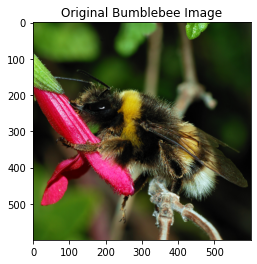

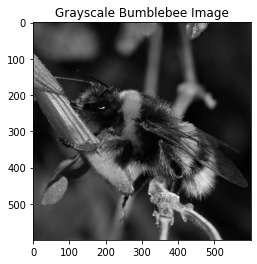

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Load and display the sample image
sample_image = imread("Files/bumblebee.png")
sample_image = sample_image.astype(float)
print("Sample image shape:", sample_image.shape)

# Original image
plt.imshow(sample_image.astype('uint8'))
plt.title("Original Bumblebee Image")
plt.show()

# Convert to grayscale
grey_sample_image = sample_image.sum(axis=2) / 3.
grey_sample_image = grey_sample_image[:, :, np.newaxis]
plt.imshow(np.squeeze(grey_sample_image.astype('uint8')), cmap=plt.cm.gray)
plt.title("Grayscale Bumblebee Image")
plt.show()

# Step 2: Applying a Simple Convolution


Convolution Weights Length: 2


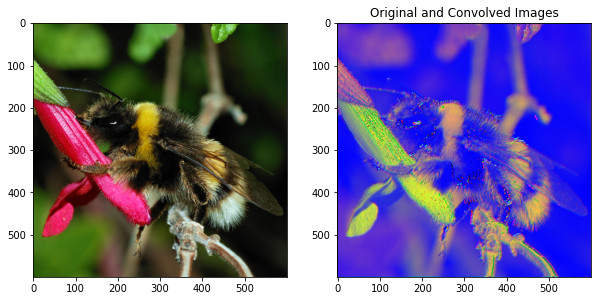


Convolution kernel shape: (5, 5, 3, 3)

Convolution biases shape: (3,)


In [11]:
# Define a simple convolution model
conv = Sequential([Conv2D(filters=3, kernel_size=(5, 5), padding="same", input_shape=(None, None, 3))])
print("\nConvolution Weights Length:", len(conv.get_weights()))

# Prepare image for prediction
img_in = np.expand_dims(sample_image, 0)
img_out = conv.predict(img_in)

# Display original and convolved images
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'))
plt.title("Original and Convolved Images")
plt.show()

# Inspect weights
weights = conv.get_weights()[0]
print("\nConvolution kernel shape:", weights.shape)

# One bias per output channel.
biases = conv.get_weights()[1]
print("\nConvolution biases shape:", biases.shape)

# Step 3: Custom Convolution Kernels


Convolution_Average shape: (None, None, None, 3)


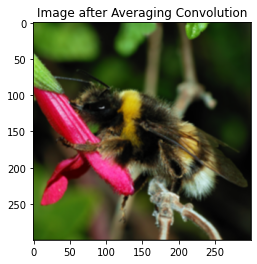

In [12]:
# Define a custom kernel initializer for averaging
def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=dtype)
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

# Build convolution model with custom kernel
conv_avg = Sequential([Conv2D(filters=3, kernel_size=(5, 5), padding="same", strides=2, input_shape=(None, None, 3), kernel_initializer=my_init)])
print("\nConvolution_Average shape:", conv.output_shape)

# Apply to the image
img_out_avg = conv_avg.predict(img_in)

# Display
plt.imshow(img_out_avg[0].astype('uint8'))
plt.title("Image after Averaging Convolution")
plt.show()

# Step 4: Edge Detection with Convolutions

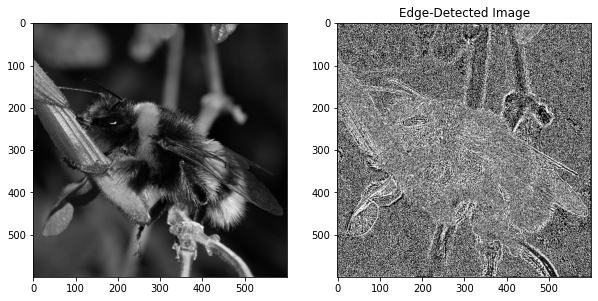

In [13]:
# Define an edge detection kernel
def edge_init(shape=(3, 3, 1, 1), dtype=None):
    array = np.array([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], dtype=dtype).reshape(shape)
    return array

# Build convolution model for edge detection
conv_edge = Sequential([Conv2D(filters=1, kernel_size=(3, 3), padding="same", input_shape=(None, None, 1), kernel_initializer=edge_init)])

# Prepare grayscale image
grey_img_in = np.expand_dims(grey_sample_image, 0)
grey_img_out = conv_edge.predict(grey_img_in)

# Display
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(np.squeeze(grey_img_in[0]).astype('uint8'), cmap=plt.cm.gray)
ax1.imshow(np.squeeze(grey_img_out[0]).astype('uint8'), cmap=plt.cm.gray)
plt.title("Edge-Detected Image")
plt.show()

# PART II

# Step 1: Extracting Files

In [14]:
import cv2
import h5py
import os.path as op
from zipfile import ZipFile

# Check if the images are extracted
if not op.exists("Downloads/images_resize"):
    zf = ZipFile('Files/images_pascalVOC.zip')
    zf.extractall('Downloads')
    print('Images extracted')
else:
    print(f'Already downloaded')

Already downloaded


# Step 2: Using a Pretrained ResNet50 Model


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

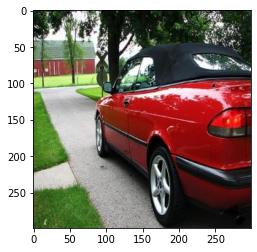

In [15]:
# Load the ResNet50 model with ImageNet weights
model = ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
print(model.summary())

# Load and preprocess the image
path = "Downloads/images_resize/000007.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
plt.imshow(img)

# plt.title("Original Image")
# plt.show()

# Resize and preprocess for ResNet50
img = cv2.resize(img, (224, 224)).astype("float32")
img_batch = preprocess_input(img[np.newaxis])

# Predict and decode the top predictions
predictions = model.predict(img_batch)
decoded_predictions = decode_predictions(predictions, top=3)

print("\nTop predictions:")
for _, name, score in decoded_predictions[0]:
    print(f"{name}: {score:.4f}")

# Step 3: Extracting Image Representations

In [16]:
# Create a model to extract features from the second-to-last layer
input = model.layers[0].input
output = model.layers[-2].output
base_model = Model(input, output)
print("\nFeature extraction model output shape:", base_model.output_shape)

# Extract representation
representation = base_model.predict(img_batch)
print("\nShape of representation:", representation.shape)
print(f"\nProportion of zeros in the feature vector: {np.mean(representation[0] == 0):.3f}")


Feature extraction model output shape: (None, 2048)

Shape of representation: (1, 2048)

Proportion of zeros in the feature vector: 0.115


# Step 4: Visualizing Image Embeddings with t-SNE

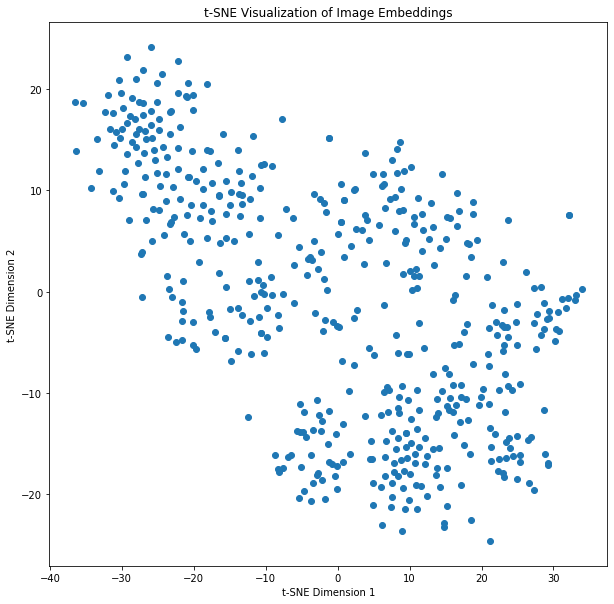

In [17]:
from sklearn.manifold import TSNE

# Load precomputed embeddings
with h5py.File('Files/img_emb.h5', 'r') as h5f:
    out_tensors = h5f['img_emb'][:]

# Apply t-SNE for dimensionality reduction
img_emb_tsne = TSNE(perplexity=30).fit_transform(out_tensors)

# Plot t-SNE
plt.figure(figsize=(10, 10))
plt.scatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1])
plt.title("t-SNE Visualization of Image Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 5: Displaying Images on t-SNE Plot

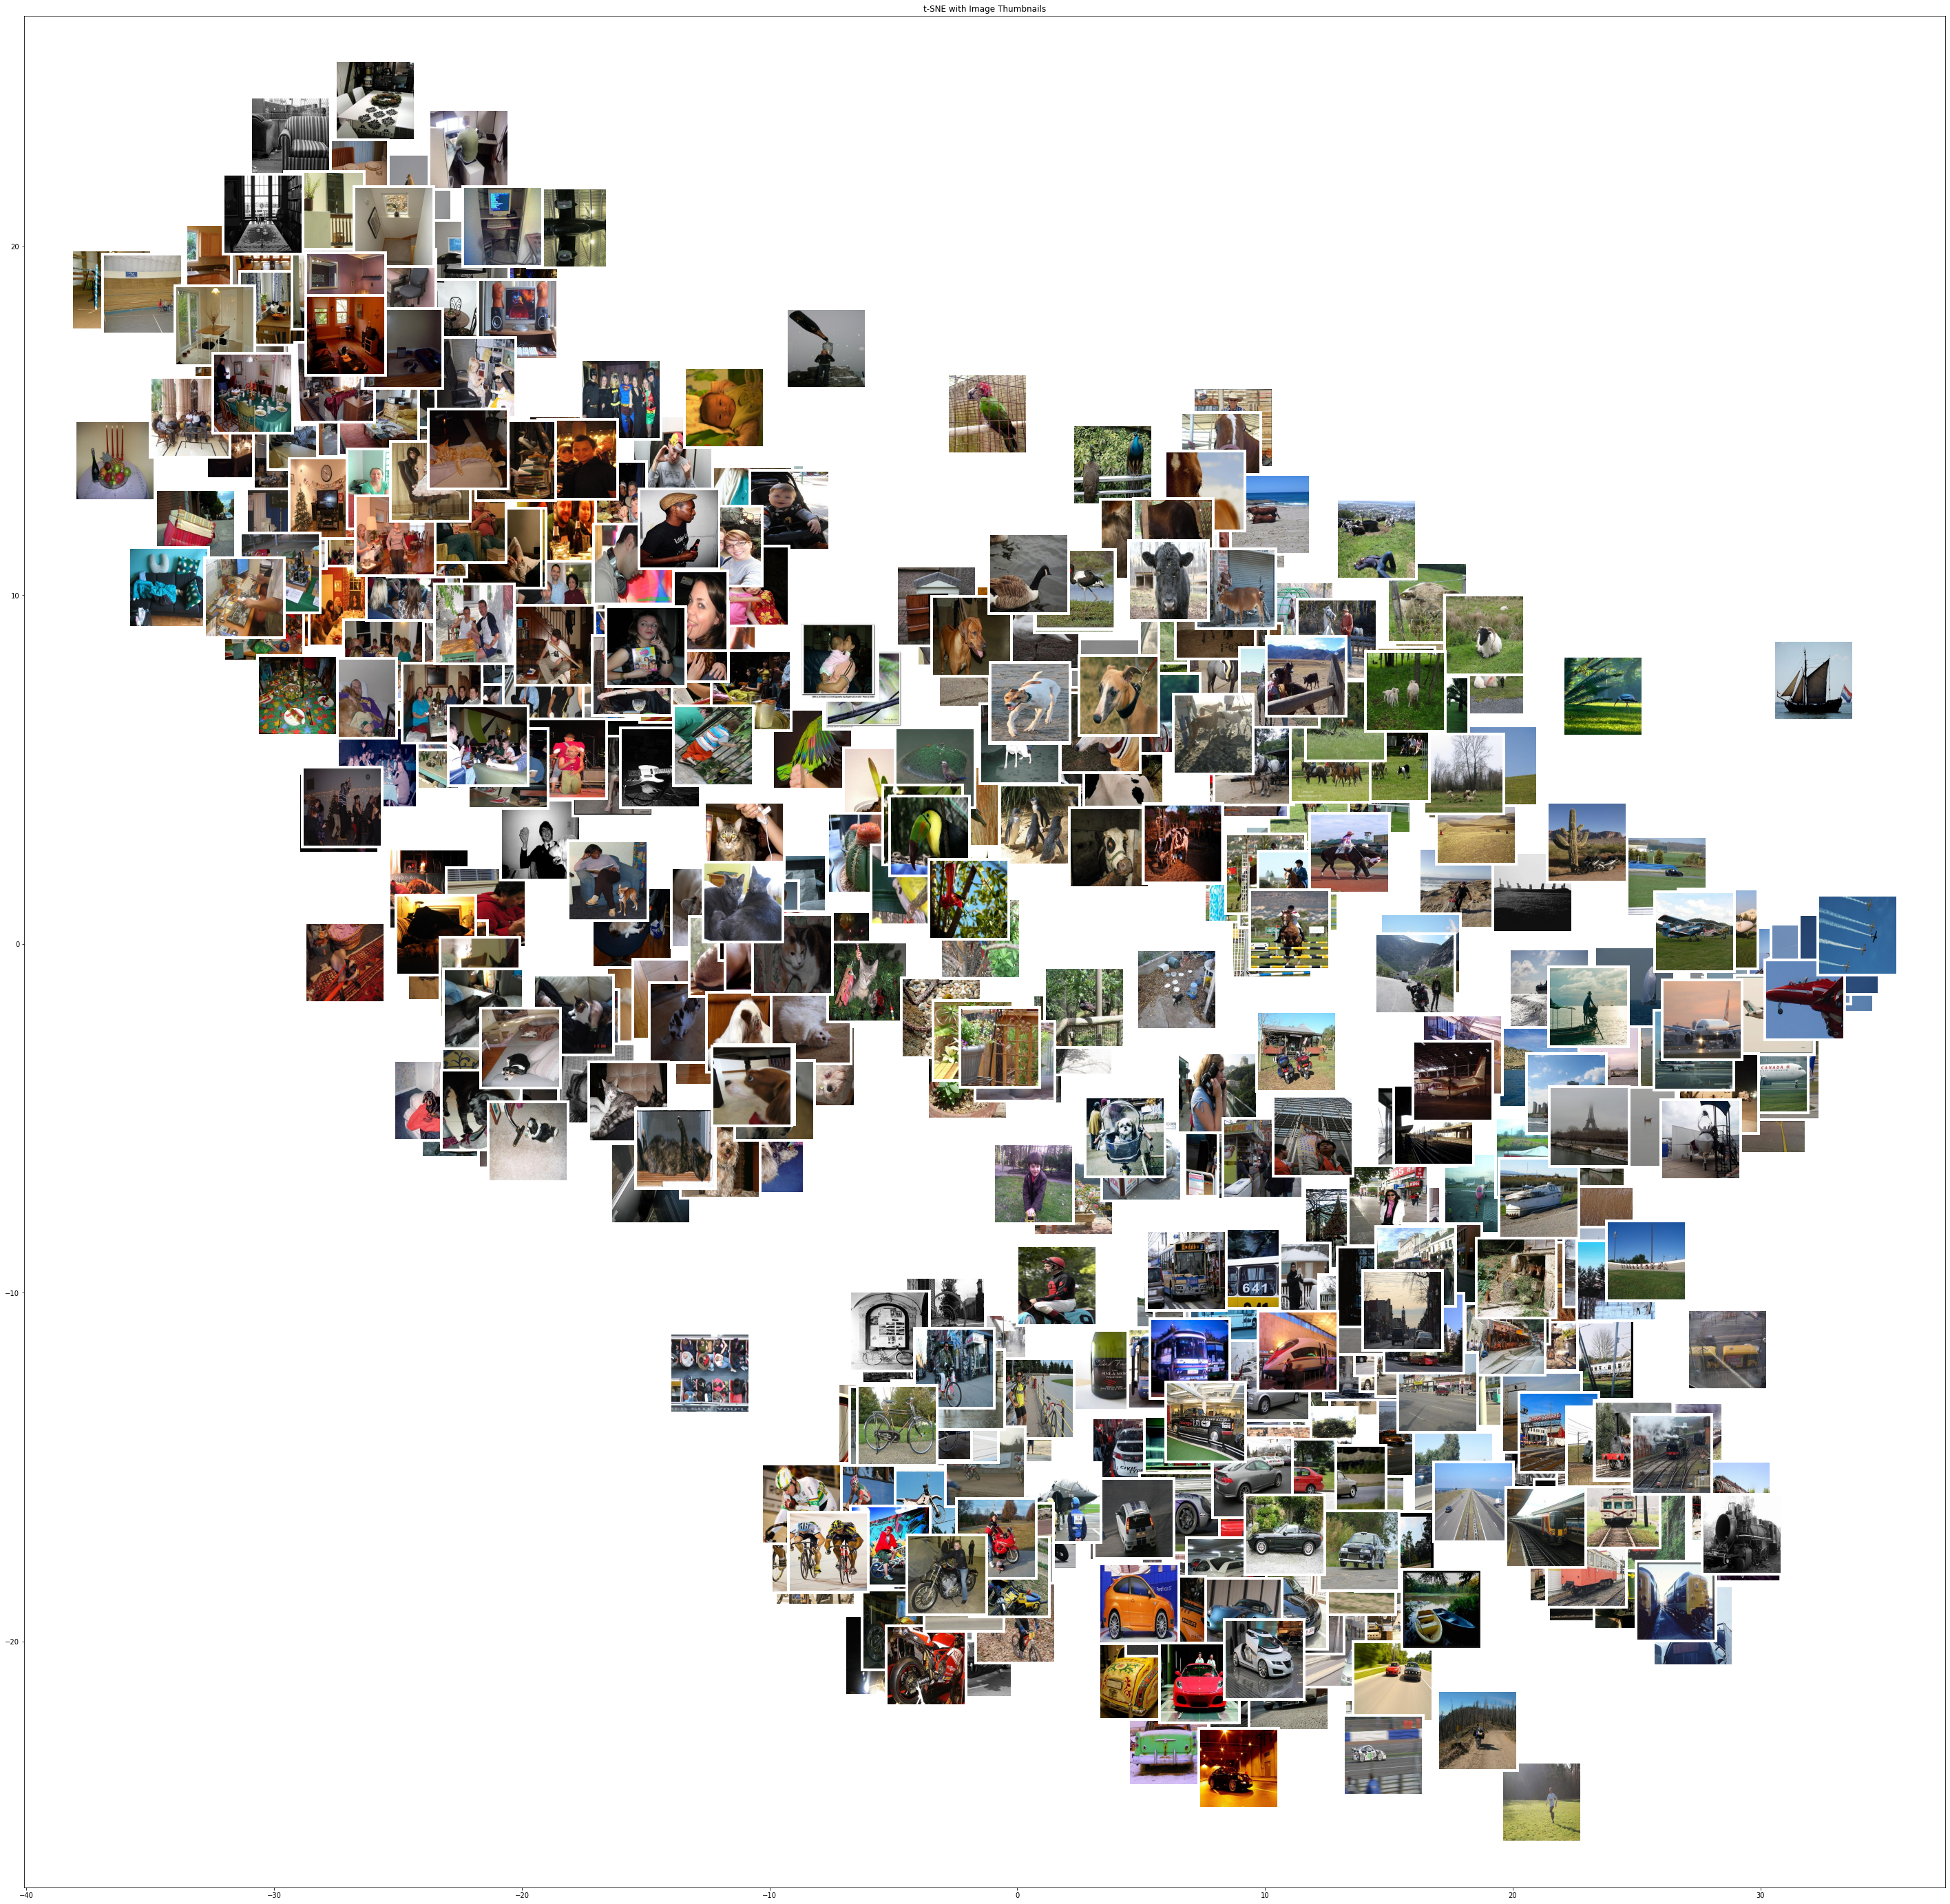

In [19]:
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Get image paths
paths = ["Downloads/images_resize/" + path for path in sorted(os.listdir("Downloads/images_resize/"))]

# Function to scatter images on the plot
def imscatter(x, y, paths, ax=None, zoom=0.5):
    if ax is None:
        ax = plt.gca()
    
    artists = []

    for x0, y0, p in zip(x, y, paths):
        try:
            im = imread(p)
            im = resize(im, (224, 224), preserve_range=False, mode='reflect')
            im = OffsetImage(im, zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), frameon=True, bboxprops=dict(edgecolor='red', linewidth=0))
            artists.append(ax.add_artist(ab))
        except Exception as e:
            print(f"Error loading image {p}: {e}")

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


# Plot with images
fig, ax = plt.subplots(figsize=(50, 50))
imscatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1], paths, ax=ax)
plt.title("t-SNE with Image Thumbnails")
plt.show()